In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gdown
import os
import yaml

from core.controllers.quadrotor_diffusion_policy import build_networks_from_config
from core.dataset.quadrotor_dataset import PlanarQuadrotorStateDataset
from core.trainers.quadrotor_diffusion_policy_trainer import PlanarQuadrotorDiffusionPolicyTrainer

/home/yif/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load config

In [3]:
with open("config/config.yaml", "r") as file:
    config = yaml.safe_load(file)

## Download dataset

In [4]:
dataset_path = "trn_data.joblib"
if not os.path.isfile(dataset_path):
    gdown.download(id="14safYt34YKn21vL9c_BsRHaG_URPB4Dp", output=dataset_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=14safYt34YKn21vL9c_BsRHaG_URPB4Dp
From (redirected): https://drive.google.com/uc?id=14safYt34YKn21vL9c_BsRHaG_URPB4Dp&confirm=t&uuid=6ffc9cbc-b325-4464-9229-ba698e15aa10
To: /home/yif/Documents/KTH/git/diffusion_policy_quadrotor/trn_data.joblib
100%|██████████| 258M/258M [00:15<00:00, 17.1MB/s] 


## Load dataset and instantiate the NN

In [5]:
dataset = PlanarQuadrotorStateDataset(dataset_path=dataset_path, config=config)
print("Dataset loaded successfully.")

net = build_networks_from_config(config)
print("Networks initialized successfully.")

Dataset loaded successfully.
Networks initialized successfully.


## Instantiate the trainer

In [6]:
trainer = PlanarQuadrotorDiffusionPolicyTrainer(
    net=net,
    dataset=dataset,
    config=config,
)

## Start training

In [7]:
trainer.train(num_epochs=100, save_ckpt_epoch=50)
trainer.save_checkpoint("ckpt_final.ckpt")

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]


Epoch: 100%|██████████| 100/100 [5:58:54<00:00, 215.34s/it, loss=0.0062]  


## Trainnig data visualization
The training data was generated using a MPPI-CBF controller from [shaoanlu/mppi_cbf](https://github.com/shaoanlu/mppi_cbf) repository. 

In [8]:
import joblib
import numpy as np
from matplotlib import pyplot as plt

In [9]:
def visualize_dataset(data):
    """
    Shows 20 samples in the dataset.
    Each subplot illustrates a training trajectory consisting of:
    - The starting position as a green dot;
    - The goal position as a red dot;
    - The positon of the quadrotor is the blue line; and
    - The obstacles are presented as grey circles.
    """
    plt.figure(figsize=(10, 8))
    for i in range(20):
        rand_idx = np.random.randint(len(data["state"]))
        s = data["state"][rand_idx]
        # des_s = data["desired_state"][rand_idx]
        info = data["info"][rand_idx]
        x, y = s[:, 0], s[:, 2]
        # des_x, des_y = des_s[:, 0], des_s[:, 2]
    
        plt.subplot(4, 5, i+1)
        for obs_idx in range(len(info["obs_center"])):
            circle = plt.Circle((info["obs_center"][obs_idx, 0], info["obs_center"][obs_idx, 1]), info["obs_radius"][obs_idx], color='grey', fill=True, linestyle='--', linewidth=2, alpha=0.5)
            plt.gca().add_artist(circle)
        plt.scatter(data["state"][rand_idx][0, 0], data["state"][rand_idx][0, 2], color="green")
        plt.scatter(5, 5, color="red")
        plt.plot(x, y)
        # plt.plot(des_x, des_y, ":")
        plt.grid()
        plt.xlim(-1, 7)
        plt.ylim(-1, 7)
    plt.tight_layout()
    plt.show()

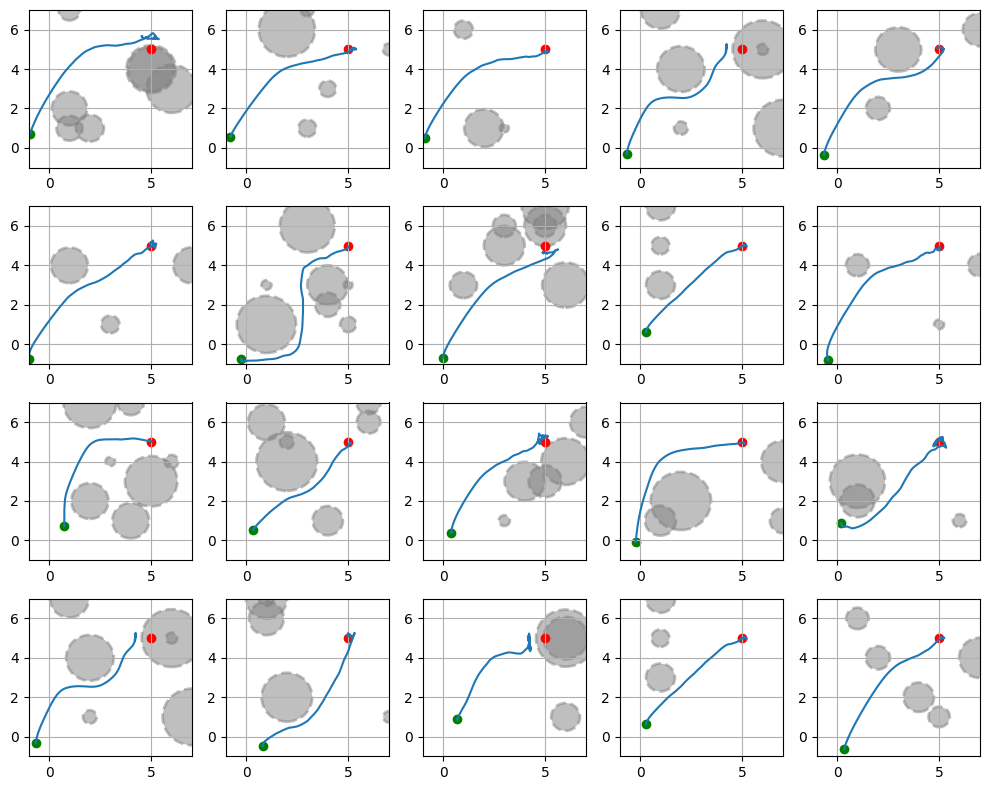

In [12]:
trn_data = joblib.load("trn_data.joblib")
visualize_dataset(trn_data)

In [29]:
for key, value in trn_data.items():
    print(f"{key}: {len(value)}")
print(trn_data["state"][0].shape)
print(trn_data["state"][0][10])
print(trn_data["desired_state"][0][10])
print(trn_data["control"][0].shape)
# type(trn_data["state"][0])
print(trn_data["info"][0])


state: 291
desired_state: 291
control: 291
info: 291
(234, 6)
[ 0.68827111 -0.00653709  0.23121421  1.52739835 -0.02047341 -1.06007409]
[ 0.68828046 -0.00794437  0.23217849  1.52743375 -0.02089023 -1.06007421]
(234, 54, 2)
{'num_obstacles': 6, 'obs_center': array([[6., 6.],
       [7., 3.],
       [7., 3.],
       [4., 4.],
       [1., 5.],
       [2., 6.]], dtype=float32), 'obs_radius': array([0.6630517 , 0.47438774, 1.1158347 , 0.4079754 , 0.7352106 ,
       0.33419135], dtype=float32), 'mppi_horizon': 54, 'init_pos': (0.6889298710555856, 0.19244269443622053)}
